# Studying Coronavirus

## Parameters

In [1]:
import time
starttotal = time.time()

import networkx as nx
import random
from random import sample
import matplotlib.pyplot as plt 
import time

In [2]:
beta = 0.3 # Infectious rate

delta = {'kid': 0.3,'adult':0.3, 'senior': 0.1} # Recovery rate
gamma = {'kid': 0.01,'adult':0.05, 'senior': 0.1} # Death rate

iterations = 1

## Generate the Network

In [3]:
# So the first part is just having a random network with random weights
import networkx as nx
import random

# Given a Network, we induce a weight reduction by *uniformely* 
# reducing weights 
# by a factor of 0<r<1
def reduceweights(G,r):
    for (u,v,w) in G.edges(data=True):
        w['weight'] = w['weight']*r

# Here n is total number of nodes, p the probability of links 
# (with random weights)
# and k and a are the proportions of kids and adults in the 
# overall population - so remember to put fractions there!
def createnetwork(n,p,k,a,r):
    G = nx.fast_gnp_random_graph(n, p, seed=None, directed=False)
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.random()
    reduceweights(G,r)
    
    for node in G.nodes:
        rd = random.random()
        if rd<k:
            G.add_node(node, age = "kid",state = "susceptible")
        elif k<rd<a+k:
            G.add_node(node, age = "adult",state = "susceptible")
        elif a+k<rd:
            G.add_node(node, age = "senior",state = "susceptible")
    # We pick 0.1% of the nodes and have them infected at initiation
    # Order of the nodes is not really relevant here
    for i in range(int(n/1000)): 
        G.add_node(i,state = "infected")
    return G

## Defining the Dynamics

In [4]:
def contagionstep(G):
    # First create a list of the infected at that stage
    infectedlist = []
    for i in G.nodes:
        if (G.nodes[i]['state']=='infected'):
            infectedlist.append(i)
    for j in infectedlist:
        for key in G[j]: 
            # look at all the nodes each infected is connected with
            # and if they are susceptible, infect with 
            # probability beta*weight
            if G.nodes[key]['state'] == 'susceptible':
                # Remember that contagion is also proportional
                # to the weight of the link infected-susceptible
                weight = G[j][key]['weight']
                if random.random()<(beta*weight):
                    G.add_node(key, state = "infected")
        # also, the infected node might die with probability gamma
        age = G.nodes[j]['age']
        if random.random()<gamma[age]:
            G.nodes[j]['state'] = 'dead'
        # or they might recover with probability delta
        # nb change to elif, because it's possible in v1 to die 
        # and then recover (which I assume was an accident)        
        elif random.random()<delta[age]:
            G.nodes[j]['state'] = 'recovered'
    return G

## Useful Functions

In [5]:
# To Color the (final) network
def colornetwork(G):
    node_color = []
    for node in G.nodes:
        # if the node has the attribute susceptible
        if G.nodes[node]['state']=='susceptible':
            node_color.append('blue')
        # if the node has the attribute infected
        elif G.nodes[node]['state']=='infected':
            node_color.append('red')
        # if the node has the attribute recovered
        elif G.nodes[node]['state']=='recovered':
            node_color.append('green')
        elif G.nodes[node]['state']=='dead':
            node_color.append('yellow')
    nx.draw(G, with_labels=False, node_size=50,node_color=node_color)
    
def countall(G):
    total = [0,0,0,0]
    for node in G.nodes:
        if G.nodes[node]['state']=='infected':
            total[0] += 1
        elif G.nodes[node]['state']=='recovered':
            total[1] += 1
        elif G.nodes[node]['state']=='susceptible':
            total[2] += 1
        elif G.nodes[node]['state']=='dead':
            total[3] += 1
    return total
    
def countinfected(G):
    infected,recovered,susceptible,dead = countall(G)
    return infected

def countdead(G):
    infected,recovered,susceptible,dead = countall(G)
    return dead

## Now for some simulations

In [6]:
# Now I define a function for running the simulations
# We are interested in studying basically two effects
# On the one hand, the total dead
# On the other, "flattening the curve". This is, looking at the maximum
# of infected during the process and see how we can reduce it
def runsimulation(n,p,k,a,r,s):
    G = createnetwork(n,p,k,a,r)
    data = []
    for i in range(s):
        G = contagionstep(G)
        data.append(countall(G))
    return data

## First we define a benchmark for comparison

The parameters are speculative.

In [7]:
def benchmark():
    # We are going to save the average of infected, recovered, suceptible,
    # and dead for each of the 150 steps of the process
    # We begin by creating an empty list
    data = []
    for i in range(150):
        data.append([0,0,0,0])

    sims=1
    for n in range(iterations):
        for r in [1,1]:
            for probs in [0.001,0.00075,0.0005]:
                for kids in [1/4,1/3]:
                    for adults in [1/3,1/2]:
                        # Now we store the data recursively averaging
                        simdata = runsimulation(10000,probs,kids,adults,r,150)
                        for j in range(150):
                            for k in range(4):
                                data[j][k] = ((data[j][k]*sims)+(simdata[j][k]))/(sims+1)
                        sims+=1

    benchmarkdata = data
    return benchmarkdata

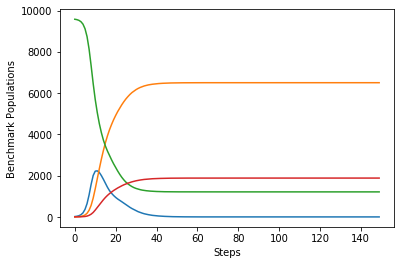

In [8]:
benchmarkdata = benchmark()

steps = []
for i in range(150):
    steps.append(i)
plt.plot(steps,benchmarkdata)
plt.ylabel('Benchmark Populations')
plt.xlabel("Steps")
plt.show()
# Green is (mean) suceptible - i.e. data[i][2]
# Blue is (mean) infected - i.e. data[i][0]
# Yellow is (mean) recovered - i.e. data[i][1]
# Red is (mean) dead - i.e. data[i][3]

## First intervention: Social Distancing

We model social distancing by (uniformely) lowering the weights in the edges of a network.

In [9]:
def socialdistancing():
    data = []
    for i in range(150):
        data.append([0,0,0,0])

    # but now we consider reduction parameters r = 0.5,0.75
    sims=1
    for n in range(iterations):
        for r in [0.5,0.75]:
            for probs in [0.001,0.00075,0.0005]:
                for kids in [1/4,1/3]:
                    for adults in [1/3,1/2]:
                        # Now we store the data recursively averaging
                        simdata = runsimulation(10000,probs,kids,adults,r,150)
                        for j in range(150):
                            for k in range(4):
                                data[j][k] = ((data[j][k]*sims)+(simdata[j][k]))/(sims+1)
                        sims+=1

    distancingdata = data
    return distancingdata

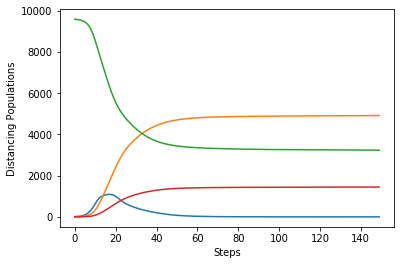

In [10]:
distancingdata = socialdistancing()
steps = []
for i in range(150):
    steps.append(i)
plt.plot(steps,distancingdata)
plt.ylabel('Distancing Populations')
plt.xlabel("Steps")
plt.show()
# Green is (mean) suceptible - i.e. data[i][2]
# Blue is (mean) infected - i.e. data[i][0]
# Yellow is (mean) recovered - i.e. data[i][1]
# Red is (mean) dead - i.e. data[i][3]

## Second Intervention: Striving for Herd Immunity

The idea here is to deliberately infect people with a high recovery rate and low mortality rate.

We model this by randomly picking one individual at each step, if they are a kid or adult and susceptible, we infect them. Otherwise, we leave it as it stands. 

In [11]:
def runherdsimulation(n,p,k,a,r,s):
    G = createnetwork(n,p,k,a,r)
    data = []
    for i in range(s):
        contagionstep(G)
        # Adding the line for deliberate infection
        # Randomly picking someone and infecting them if they are
        # not senior and were susceptible
        random_node = sample(list(G.nodes),1)
        if G.nodes[random_node[0]]['age'] != 'senior':
            if G.nodes[random_node[0]]['state'] == 'susceptible':
                G.add_node(random_node[0], state = "infected")
        data.append(countall(G))
    return data

In [12]:
def herdimmunity():
    data = []
    for i in range(150):
        data.append([0,0,0,0])

    # but now we consider reduction parameters r = 0.5,0.75
    sims=1
    for n in range(iterations):
        for r in [1,1]:
            for probs in [0.001,0.00075,0.0005]:
                for kids in [1/4,1/3]:
                    for adults in [1/3,1/2]:
                        # Now we store the data recursively averaging
                        simdata = runherdsimulation(10000,probs,kids,adults,r,150)
                        for j in range(150):
                            for k in range(4):
                                data[j][k] = ((data[j][k]*sims)+(simdata[j][k]))/(sims+1)
                        sims+=1

    herddata = data
    return herddata

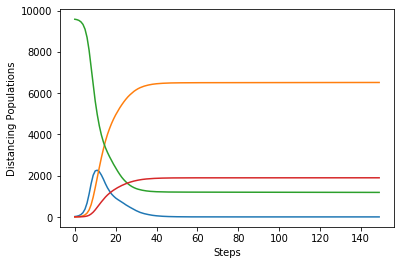

In [13]:
herddata = herdimmunity()
steps = []
for i in range(150):
    steps.append(i)
plt.plot(steps,herddata)
plt.ylabel('Distancing Populations')
plt.xlabel("Steps")
plt.show()
# Green is (mean) suceptible - i.e. data[i][2]
# Blue is (mean) infected - i.e. data[i][0]
# Yellow is (mean) recovered - i.e. data[i][1]
# Red is (mean) dead - i.e. data[i][3]

## Finally we combine both methods: Distancing and Herd

In [14]:
def both():
    data = []
    for i in range(150):
        data.append([0,0,0,0])

    sims=1
    for n in range(iterations):
        for r in [0.5,0.75]:
            for probs in [0.001,0.00075,0.0005]:
                for kids in [1/4,1/3]:
                    for adults in [1/3,1/2]:
                        # Now we store the data recursively averaging
                        simdata = runherdsimulation(10000,probs,kids,adults,r,150)
                        for j in range(150):
                            for k in range(4):
                                data[j][k] = ((data[j][k]*sims)+(simdata[j][k]))/(sims+1)
                        sims+=1

    bothdata = data
    return bothdata

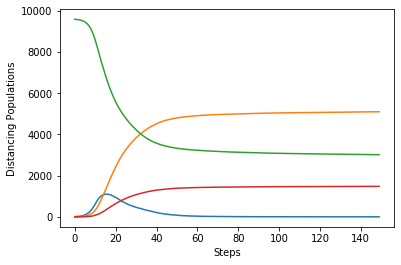

In [15]:
bothdata = both()
steps = []
for i in range(150):
    steps.append(i)
plt.plot(steps,bothdata)
plt.ylabel('Distancing Populations')
plt.xlabel("Steps")
plt.show()
# Green is (mean) suceptible - i.e. data[i][2]
# Blue is (mean) infected - i.e. data[i][0]
# Yellow is (mean) recovered - i.e. data[i][1]
# Red is (mean) dead - i.e. data[i][3]

## Comparison Plots

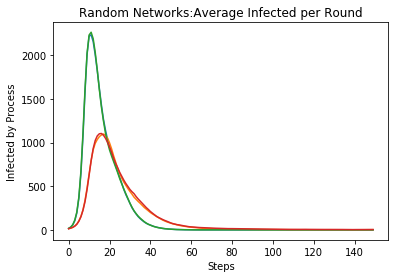

In [16]:
# Let us build a plot for infected under the four different procedures
steps = []
infected = []
for i in range(150):
    steps.append(i)
    stepdata = [benchmarkdata[i][0],distancingdata[i][0],herddata[i][0],bothdata[i][0]]
    infected.append(stepdata)
    
plt.plot(steps,infected)
plt.title('Random Networks:Average Infected per Round')
plt.ylabel('Infected by Process')
plt.xlabel("Steps")
plt.savefig("Random Networks Infected Average.png")
plt.show()
# Blue is Benchmark
# Yellow is Distancing
# Green is Herd Immunity
# Red is Both

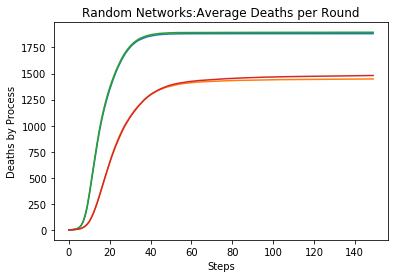

301.3890173435211


In [17]:
# Let us build a plot for deaths under the four different procedures
steps = []
infected = []
for i in range(150):
    steps.append(i)
    stepdata = [benchmarkdata[i][3],distancingdata[i][3],herddata[i][3],bothdata[i][3]]
    infected.append(stepdata)
    
plt.plot(steps,infected)
plt.title('Random Networks:Average Deaths per Round')
plt.ylabel('Deaths by Process')
plt.xlabel("Steps")
plt.savefig("Random Networks Deaths Average.png")
plt.show()
# Blue is Benchmark
# Yellow is Distancing
# Green is Herd Immunity
# Red is Both

end = time.time()
print(end - starttotal)